#  Inference test using a toy model
---
_This notebook reproduces the results of Section 6 from the paper: https://arxiv.org/abs/2108.11481_

Paper authors: S. Menary [sbmenary@gmail.com] and D. Price [darren.price@cern.ch]

Notebook author: S. Menary [sbmenary@gmail.com]

---

In this notebook we test the accuracy of maximum likelihood estimates (MLEs) and confidence level contours evaluated using our method. We do this by defining a toy model for which we know the ground truth PDF, and can therefore evaluate the true MLE and contours for comparison.

First we import packages. From our codebase, we require the **project_axes_onto_latent** method to project data onto the latent space, and the **DensityModel** class for storing and training the density model

In [1]:
#  Required imports

print("Importing standard library")
import sys, time

print("Importing python data libraries")
import numpy as np
from   scipy      import stats, special
from   matplotlib import pyplot as plt, colors, lines
from   iminuit    import Minuit

print("Importing third party libraries")
import dill as pickle

print("Importing custom backends")
sys.path.append("/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation")
from backends.density_model    import DensityModel
from backends.plot             import histo_to_line
from backends.stats            import project_axes_onto_latent
from backends.utils            import make_sure_dir_exists_for_filename


Importing standard library
Importing python data libraries
Importing third party libraries
Importing custom backends


## 1. Configuration

We now configure our density model.


In [2]:
#=====================================#
#==   Density model configuration   ==#
#=====================================#

num_gaussians            = 20       #  num. Gaussians used in the mixture models
max_epochs               = 300      #  num. epochs to train for
batch_size               = 500      #  training batch size
early_stopping_patience  = 8        #  num. epochs training will stop after if insufficient improvement
early_stopping_min_delta = 1e-6     #  minimum improvement in log-likelihood considered "sufficient"
validation_split         = 0.4      #  fraction of data to be used in validation set (between 0 and 1)

gauss_width_factor = 1./4.       #  model constant f_sigma
gauss_mean_scale   = 1./100.     #  model constant s_mu
gauss_frac_scale   = 1./100.     #  model constant s_f
gauss_sigma_scale  = 1./100.     #  model constant s_sigma
A1                 = 50          #  model constant A1
A2                 = 0           #  model constant A2
B1                 = 50          #  model constant B1
B2                 = 20          #  model constant B2
C_float            = 2           #  model constant C  (tused for modelling floating point observables)
D                  = 3           #  model constant D
batch_norm         = False       #  whether to use batch_norm layers [bool] [dflt: False]
dropout            = -1.         #  dropout fraction (negative means not used) [dflt: -1]

learning_rate              = 1e-3      #  training constant lambda_learning_rate
learning_rate_evo_factor   = 0.5       #  training constant lambda_update_factor
learning_rate_evo_patience = 2         #  training constant lambda_patience
optimiser                  = "adam"    #  optimisation algorithm [dflt: adam]


We now configure our program. These settings steer the notebook, e.g. by deciding whether to load data or generate it on-the-fly.

In [3]:
#================================#
#==   Steering configuration   ==#
#================================#

n_gen    = int(5e4)  #  num. datapoints to generate at each training point in the (c_x,c_y)-plane
n_true   = int(4e2)  #  num. datapoints in the "observed" datasets used to perform inference
n_sample = 10*n_gen  #  num. datapoints sampled from density model to test agreement with truth

run_tag = "model_inference_dense"  #  tag used to label the plots, models, datasets etc

density_model_filename        = f".InferTest_{run_tag}"  # name of density model save file
load_density_model_from_file  = True                     # True: load model, False: train model and save

train_datasets_filename       = f"../Data/.InferTest_train_data_{run_tag}.pickle"  # name of file storing datasets for training
load_train_datasets_from_file = True                                               # True: load, False: generate and save

toy_datasets_filename         =  "../Data/.InferTest_toy_data.pickle"  # name of file storing toy datasets for inference
load_toy_datasets_from_file   = True                                   # True: load, False: generate and save

projection_functions_filename = f"../Data/.InferTest_proj_funcs_{run_tag}.pickle"  # name of file storing projection functions
load_proj_funcs_from_file     = True                                               # True: load, False: generate and save

skip_sampling = True    #  False (dflt): sample density model n_sample times and plot, True: skip this to save time

#  set the c_x and c_y values used to create grid of traing data
c_x_gen, c_y_gen = np.linspace(-1.5, 1.5, 7), np.linspace(-1.5, 1.5, 7)
if run_tag == "model_inference_dense" :
    c_x_gen, c_y_gen = np.array([-1.5, -1, -0.5, -0.2, 0, 0.2, 0.5, 1, 1.5]), np.array([-1.5, -1, -0.5, -0.2, 0, 0.2, 0.5, 1, 1.5])


## 2. Define toy model

We now define the ground truth PDF and methods for sampling from it. We define and sample the PDF using an autoregressive probability density: 

\begin{equation}
p \left( \vec x \right) ~=~ \prod_{~i~=~0}^{~j~<~{\rm dim} (x)} p \left( x_i | x_{<i} \right)
\end{equation}

In [4]:
#  Define any constants associated with the model

num_observables = 4

In [5]:
#  Define observable ranges (x3 has no limits)

x0_range = [100., 800.]
x1_range = x0_range
x2_range = [-np.pi, np.pi]

In [6]:
#  Define PDF and sampling method for observable x0

def p_x0 (c, x0) :
    """return PDF p(x0|c) where c has two components"""
    c  = np.fabs(c[0])
    x0 = (x0 - x0_range[0]) / (x0_range[1] - x0_range[0])
    A  = 2.
    N  = A*(2-c) / (1. - np.exp(-A*(2-c)))
    return N * np.exp(-A*(2-c)*x0) / (x0_range[1] - x0_range[0])
    
def int_x0 (c, x0) :
    """return CDF of observable x0 where c has two components"""
    c  = np.fabs(c[0])
    x0   = (x0 - x0_range[0]) / (x0_range[1] - x0_range[0])
    A    = 2.
    N    = A*(2-c) / (1. - np.exp(-A*(2-c)))
    zero = - N / (A*(2-c))
    return - (N * np.exp(-A*(2-c)*x0) / (A*(2-c))) - zero

def inv_int_x0 (c, I0) :
    """return inverse of the CDF of observable x0 where c has two components"""
    c  = np.fabs(c[0])
    A  = 2.
    N  = A*(2-c) / (1. - np.exp(-A*(2-c)))
    x0 = - np.log(1 - A*(2-c)/N*I0) / A / (2-c)
    return x0_range[0] + x0*(x0_range[1] - x0_range[0])

In [7]:
#  Define PDF and sampling method for observable x1

def p_x1 (c, x0, x1) :
    """return PDF p(x0|x1,c) where c has two components"""
    c     = np.fabs(c[0])
    x0    = (x0 - x0_range[0]) / (x0_range[1] - x0_range[0])
    x1    = (x1 - x1_range[0]) / (x1_range[1] - x1_range[0])
    sigma = 0.05
    N     = - np.sqrt(0.5*np.pi) * sigma * (special.erf((x0 - 1.) / np.sqrt(2) / sigma) - special.erf((x0 - 0.) / np.sqrt(2) / sigma))
    return np.exp(-(x1-x0)*(x1-x0)/2./sigma/sigma) / N / (x1_range[1] - x1_range[0])
    
def int_x1 (c, x0, x1) :
    """return CDF of observable x1 where c has two components"""
    c     = np.fabs(c[0])
    x0    = (x0 - x0_range[0]) / (x0_range[1] - x0_range[0])
    x1    = (x1 - x1_range[0]) / (x1_range[1] - x1_range[0])
    sigma = 0.05
    N     = special.erf((x0 - 1.) / np.sqrt(2) / sigma) - special.erf((x0 - 0.) / np.sqrt(2) / sigma)
    intgl = special.erf((x0 - x1) / np.sqrt(2) / sigma) - special.erf((x0 - 0.) / np.sqrt(2) / sigma)
    return intgl / N

def inv_int_x1 (c, x0, I1) :
    """return inverse of the CDF of observable x1 where c has two components"""
    c     = np.fabs(c[0])
    r     = (x1_range[1] - x1_range[0])
    x0    = (x0 - x0_range[0]) / (x0_range[1] - x0_range[0])
    sigma = 0.05
    N     = special.erf((x0 - 1.) / np.sqrt(2) / sigma) - special.erf((x0 - 0.) / np.sqrt(2) / sigma)
    zero  = special.erf((x0 - 0.) / np.sqrt(2) / sigma)
    x1    = x0 - sigma * np.sqrt(2) * special.erfinv(N*I1 + zero)
    return x1_range[0] + x1*(x1_range[1] - x1_range[0])

In [8]:
#  Define PDF and sampling method for observable x2

def p_x2 (c, x2) :
    """return PDF p(x2|c) where c has two components"""
    c0, c1 = c[0], c[1]
    A, B, C, D, E = 1., 4./np.pi/np.pi, -5./np.pi/np.pi/np.pi/np.pi, 0.4*c0, 0.5*c1
    y = (A + B*x2*x2 + C*x2*x2*x2*x2) * (1 + D*np.sin(x2) + E*np.cos(x2))
    I = int_f2(c, np.pi) - int_f2(c, -np.pi)
    return y / I
        
def int_f2 (c, x) :
    """helper function for the CDF of observable x2 (lacks normalisation factor)"""
    c0, c1 = c[0], c[1]
    A, B, C, D, E = 1., 4./np.pi/np.pi, -5./np.pi/np.pi/np.pi/np.pi, 0.4*c0, 0.5*c1
    sin_factor =  A*E + 2*B*D*x + B*E*(x*x-2) + 4*C*D*x*(x*x-6) + C*E*(x*x*x*x - 12*x*x + 24)
    cos_factor = -A*D + 2*B*E*x - B*D*(x*x-2) + 4*C*E*x*(x*x-6) - C*D*(x*x*x*x - 12*x*x + 24)
    I = sin_factor*np.sin(x) + cos_factor*np.cos(x) + A*x + B*x*x*x/3. + C*x*x*x*x*x/5.
    return I 
    
def int_x2 (c, x2) :
    """return inverse of the CDF of observable x2 where c has two components"""
    I_lo = int_f2(c, -np.pi)
    I_hi = int_f2(c, np.pi )
    I_x  = int_f2(c, x2    )
    return (I_x - I_lo) / (I_hi - I_lo)

def inv_int_x2 (c, I2, n_pt=1001) :
    """numerically estimate the inverse of the CDF of observable x2 where c has two components"""
    x = np.linspace(-np.pi, np.pi, n_pt)
    y = int_x2(c, x)
    return np.interp(I2, y, x)

In [9]:
#  Define PDF and sampling method for observable x3

alpha_x, beta_x, gamma_x = 10, 1, 1
f1_x         = np.exp(2*(alpha_x*beta_x+gamma_x)) / alpha_x / (np.exp(2*(alpha_x*beta_x+gamma_x)) - 1) 
int_const_x  = (alpha_x*beta_x + gamma_x) * f1_x
norm_const_x = 2 * int_const_x

def base_prob (x) :
    """return PDF of a smooth continuous distribution around 0 with constants alpha_x, beta_x and gamma_x"""
    return 1. / (1 + np.exp(alpha_x*(x-beta_x)-gamma_x)) / (1 + np.exp(-alpha_x*(x+beta_x)-gamma_x)) / norm_const_x
    
def base_int (x) :
    """return CDF of PDF base_prob"""
    f2 = np.exp(alpha_x*(beta_x+x) + gamma_x) + 1
    f3 = np.exp(alpha_x*beta_x + gamma_x) + np.exp(alpha_x*x)
    return (f1_x * np.log( f2 / f3 ) + int_const_x) / norm_const_x

def base_inv (I) :
    """return inverse of method base_int"""
    L   = np.exp( (I*norm_const_x - int_const_x) / f1_x )
    num = L*np.exp(alpha_x*beta_x + gamma_x) - 1.
    den = np.exp(alpha_x*beta_x + gamma_x) - L
    return np.log(num / den) / alpha_x

def p_x3 (c, x0, x1, x2, x3) :
    """return PDF p(x3|x0,x1,x2,c) where c has two components"""
    c0, c1 = c[0], c[1]
    x0 = 2*(x0 - x0_range[0]) / (x0_range[1] - x0_range[0]) - 1.
    x1 = 2*(x1 - x1_range[0]) / (x1_range[1] - x1_range[0]) - 1.
    x2 = (x2 + np.pi) / np.pi - 1.
    x3 = x3 + .6*(np.sqrt(4. + np.fabs(c0)) + np.fabs(c1))*(x1 + x2)
    return base_prob(x3)
    
def int_x3 (c, x0, x1, x2, x3) :
    """return CDF of observable x3 where c has two components"""
    c0, c1 = c[0], c[1]
    x0 = 2*(x0 - x0_range[0]) / (x0_range[1] - x0_range[0]) - 1.
    x1 = 2*(x1 - x1_range[0]) / (x1_range[1] - x1_range[0]) - 1.
    x2 = (x2 + np.pi) / np.pi - 1.
    x3 = x3 + .6*(np.sqrt(4. + np.fabs(c0)) + np.fabs(c1))*(x1 + x2)
    return base_int(x3)

def inv_int_x3 (c, x0, x1, x2, I3) :
    """return inverse of the CDF of observable x3 where c has two components"""
    c0, c1 = c[0], c[1]
    x0 = 2*(x0 - x0_range[0]) / (x0_range[1] - x0_range[0]) - 1.
    x1 = 2*(x1 - x1_range[0]) / (x1_range[1] - x1_range[0]) - 1.
    x2 = (x2 + np.pi) / np.pi - 1.
    u3 = base_inv(I3)
    return base_inv(I3) - .6*(np.sqrt(4. + np.fabs(c0)) + np.fabs(c1))*(x1 + x2)

In [10]:
#  Define total PDF and sampling methods

def evaluate_true_PDF (c, x) :
    """return true PDF p(x|c) where c has two components and x is a single point or a dataset of size [?,4]"""
    if type(x) != np.ndarray : x = np.array(x)
    if len(x.shape) == 1 : x = x.reshape(1, len(x))
    logL = np.log(p_x0(c, x[:,0])) + np.log(p_x1(c, x[:,0], x[:,1])) + np.log(p_x2(c, x[:,2])) + np.log(p_x3(c, x[:,0], x[:,1], x[:,2], x[:,3]))
    return np.sum(logL)

def generate_true_datapoints (c, n_pts) :
    """sample n_pts datapoints from the true PDF evaluated at c, which has 2 components"""
    u0 = np.random.uniform(low=0, high=1, size=int(n_pts))
    x0 = inv_int_x0(c, u0)
    u1 = np.random.uniform(low=0, high=1, size=int(n_pts))
    x1 = inv_int_x1(c, x0, u1)
    u2 = np.random.uniform(low=0, high=1, size=int(n_pts))
    x2 = inv_int_x2(c, u2)
    u3 = np.random.uniform(low=0, high=1, size=int(n_pts))
    x3 = inv_int_x3(c, x0, x1, x2, u3)
    return np.array([x0, x1, x2, x3]).transpose()


##  3. Generate true data

We now generate the training/validation data across our grid of c_x_gen, c_y_gen. If requested, we load these from a file instead (for reproducibility).


In [11]:
#  Determine pairs of c_x and c_y which make up our training grid

c_gen = []
for c_x in c_x_gen :
    for c_y in c_y_gen :
        c_gen.append((c_x, c_y))

In [12]:
#  Load datapoints if requested (only works if file already exists)
#     otherwise create empty container to be filled with newly generate datapoints

if load_train_datasets_from_file :
    print(f"Loading training+validation data from file {train_datasets_filename}")
    datapoints_dict = pickle.load(open(train_datasets_filename, "rb"))
else :
    datapoints_dict = {}

Loading training+validation data from file ../Data/.InferTest_train_data_model_inference_dense.pickle


In [13]:
#  Generate event weights (and new datapoints if required)
        
weights_dict = {}
for c in c_gen :
    if c not in datapoints_dict :
        print(f"Generating new training+validation data at c = {c}")
        datapoints_dict[c] = generate_true_datapoints(c, n_gen)
    weights_dict[c] = np.ones(shape=(n_gen,))
    

In [14]:
#  Save event weights if new ones were generated

if not load_train_datasets_from_file :
    print(f"Saving training+validation data from to {train_datasets_filename}")
    pickle.dump(datapoints_dict, open(train_datasets_filename, "wb"))

In [15]:
#  Infer range of observable x3 based on the observed data

x3_range = [np.min([datapoints_dict[c][:,3] for c in c_gen]), np.max([datapoints_dict[c][:,3] for c in c_gen])]

print(f"x3_range is {x3_range}")


x3_range is [-5.620260737798274, 5.84541612891722]


We now visualise the data we have generated/loaded.

In [16]:
#  define method to perform plotting of data

def visualise_data_physical_space (plot_c_vals, title="", savefig=None) :
    """plot data for values of plot_c_vals before projecting onto latent space"""
    prop_cycle = plt.rcParams['axes.prop_cycle']
    colours    = prop_cycle.by_key()['color']
    num_rows   = len(plot_c_vals)
    fig = plt.figure(figsize=(15, 6*num_rows))
    for row_idx in range(num_rows) :
        c_offset = 5 if row_idx == 1 else 0
        axes = []
        for obs_idx in range(num_observables) :
            ax_top    = fig.add_axes([obs_idx/num_observables, (1-row_idx)*.5 + .45*0.41, 0.9/num_observables, .45*.58])
            obs_range = {0:x0_range, 1:x1_range, 2:x2_range, 3:x3_range}[obs_idx]
            hbins     = np.linspace(obs_range[0], obs_range[1], 21)
            ax_top.set_xlim([obs_range[0], obs_range[1]])
            ax_top.tick_params(axis="both", direction="in", right=True, top=True, labelsize=16, pad=5)
            ax_top.set_xticklabels([])
            if obs_idx > 0 : ax_top.set_yticklabels([])
            ypadmax, vals = 0., {}
            for c_idx, c in enumerate(plot_c_vals[row_idx]) :
                ds = datapoints_dict[c][:,obs_idx]
                vals[c], _ = np.histogram(datapoints_dict[c][:,obs_idx], bins=hbins)
                ypadmax    = np.max([ypadmax, np.max(vals[c])])
            for c_idx, c in enumerate(plot_c_vals[row_idx]) :
                colour = colours[c_offset+c_idx] if c_idx > 0 else colours[0]
                x, y, ey = histo_to_line(hbins, vals[c], np.sqrt(vals[c]))
                y, ey = y/ypadmax, ey/ypadmax
                ax_top.plot        (x, y, lw=2, label=None if row_idx>0 and c[0]==0 and c[1]==0 else f"{c}", c=colour, alpha=0.6)
                ax_top.fill_between(x, y-ey, y+ey, alpha=0.3, fc=colour)
                if (c[0] == 0) and (c[1] == 0) : ax_top.fill_between(x, 0*y, y, alpha=0.05, fc="black")
            ax_top.set_ylim(0, 1.1)

            ax_ratio = fig.add_axes([obs_idx/num_observables, (1-row_idx)*.5 + .45*0, 0.9/num_observables, .45*.37])
            ax_ratio.set_xlim([obs_range[0], obs_range[1]])
            ax_ratio.tick_params(axis="both", direction="in", right=True, top=True, labelsize=16, pad=5)
            if obs_idx > 0 : ax_ratio.set_yticklabels([])
            ax_ratio.set_ylim(-0.5, 0.5)
            ax_ratio.set_yticks([-0.4, -0.2, 0., 0.2, 0.4])
            if row_idx == 0 :
                ax_ratio.set_xticklabels([])
            else :
                ax_ratio.set_xlabel(f"$x_{obs_idx}$", fontsize=20, labelpad=25, ha="center")

            for c_idx, c in enumerate(plot_c_vals[row_idx]) :
                colour = colours[c_offset+c_idx] if c_idx > 0 else colours[0]
                x, y, ey       = histo_to_line(hbins, vals[c], np.sqrt(vals[c]))
                _, y_SM, ey_SM = histo_to_line(hbins, vals[(0,0)], np.sqrt(vals[(0,0)]))
                y, ey, y_SM, ey_SM = y/ypadmax, ey/ypadmax, y_SM/ypadmax, ey_SM/ypadmax
                ey_comb = np.sqrt(ey*ey + ey_SM*ey_SM)
                if (c[0] == 0) and (c[1] == 0) : ey_comb = 0.*ey_comb
                ax_ratio.plot        (x, y - y_SM, lw=2, c=colour, alpha=0.6)
                ax_ratio.fill_between(x, y - y_SM - ey_comb, y - y_SM + ey_comb, alpha=0.3, fc=colour)

            axes.append([ax_top, ax_ratio])

        axes[-1][0].text(1.1, 1, r"($c_x$, $c_y$) =", ha="left", va="top", fontsize=18, weight="bold", transform=axes[-1][0].transAxes)
        axes[-1][0].legend(loc=(1.05, .30 if row_idx == 0 else .53), frameon=False, fontsize=16)
        axes[0 ][0].set_ylabel(r"$\frac{p_{\rm bin}}{p_{\rm max}}$", fontsize=30, rotation=0, labelpad=55)
        axes[0 ][1].set_ylabel(r"$\frac{p_{\rm bin} - p_{\rm bin}|_{(0,0)}}{p_{\rm max}}$", fontsize=30, rotation=0, labelpad=100, va="center")
        if (len(title) > 0) and (row_idx == 0) : axes[0][0].text(0, 1.15, title, ha="left", va="bottom", fontsize=28, weight="bold", transform=axes[0][0].transAxes)

    if type(savefig) is str :
        make_sure_dir_exists_for_filename(savefig)
        plt.savefig(savefig, bbox_inches="tight")
    plt.show()


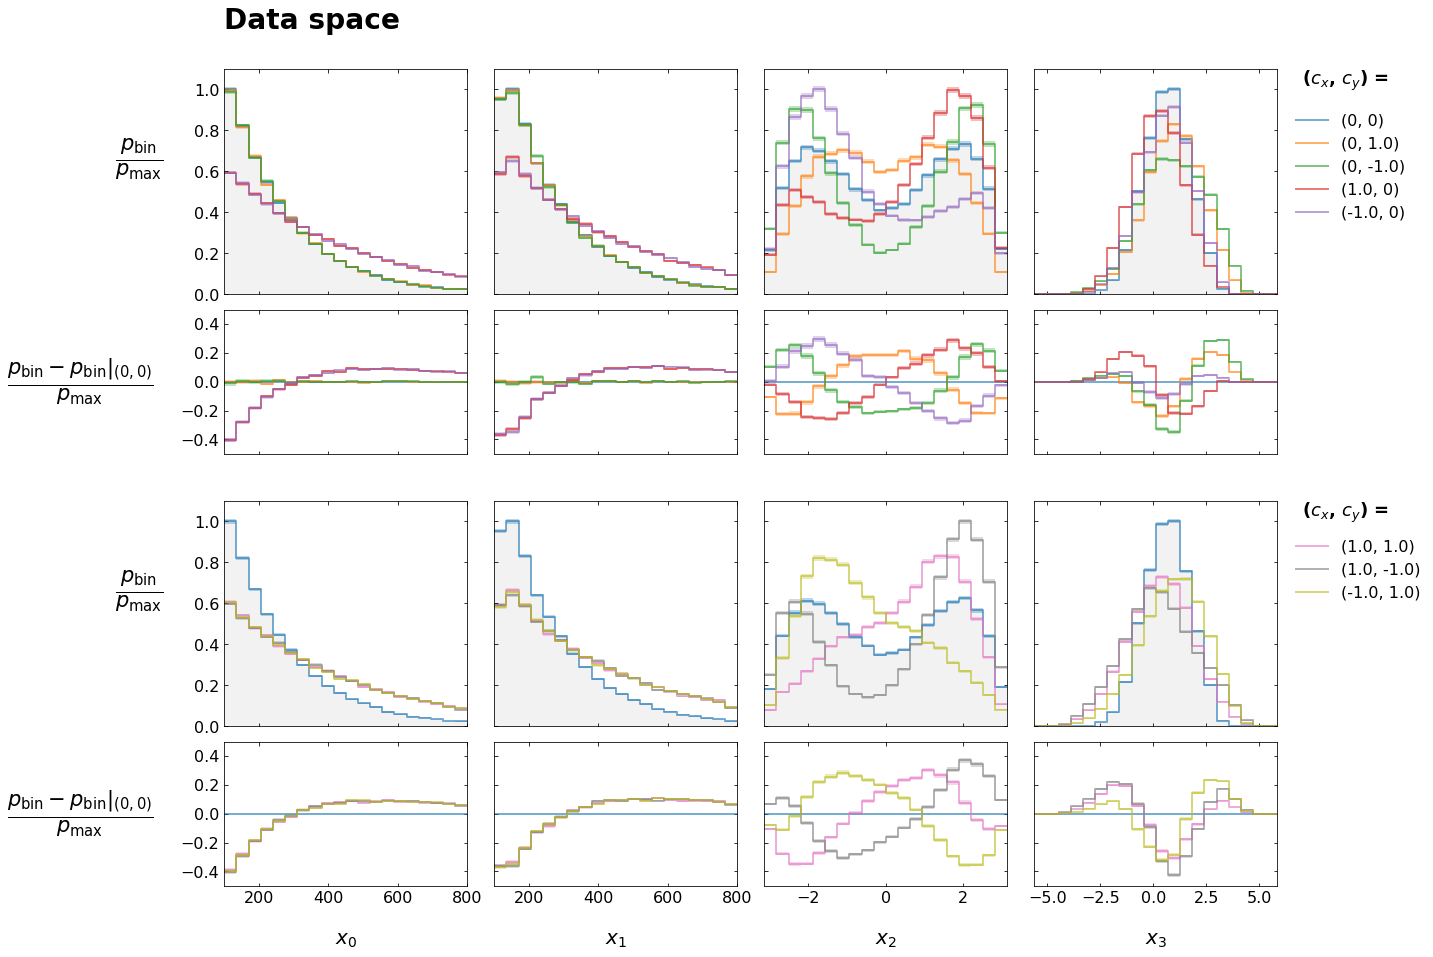

In [17]:
#  Define list-of list-of (c_x, c_y) values to plot
#    Each sub-list contains the c-values to be plotted on that row
#    Optimised for 2 rows, so may not look nice for other num_rows
plot_c_vals = [[(0, 0), (0, 1.), (0, -1.), (1., 0), (-1., 0)], [(0, 0), (1., 1.), (1., -1.), (-1., 1.)]]

#  Make and save plot
visualise_data_physical_space(plot_c_vals, title="Data space", savefig=f"figures/Figure15/Fig15_top_{run_tag}.pdf")


##  4. Project true data onto latent space

We project the data onto the latent space. If requested, we load the projection functions from a file. This is especially important when loading previously generated models, since we need to use the projections associated with the training of that model.

In [18]:
#  Make sure projection functions and model are loaded together

if load_density_model_from_file :
    if not (load_proj_funcs_from_file or load_train_datasets_from_file) :
        raise RuntimeError("Requested to load a density model from file but not projection functions or training data from which to derive them. Cannot generate projections functions using new data, as they will not match the density model you want to load.")
        

In [19]:
#  Define constants used to create projection functions (if needed)

proj_func_form = "step"
proj_alpha, proj_beta, proj_gamma = 4, 3, 1

# axis config is [low limit, high limit, num eval pts for data CDF, f-constant, f-constant on latent space (set as 0)]
axis_configs = [[x0_range[0], x0_range[1], 200, 0.5, 0.],
                [x1_range[0], x1_range[1], 200, 0.5, 0.],
                [x2_range[0], x2_range[1], 200, 0.5, 0.],
                [x3_range[0], x3_range[1], 200, 0.5, 0.]]

In [20]:
#  Load projection functions from file, or else create new ones

if load_proj_funcs_from_file :
    print(f"Loading projection functions from file {projection_functions_filename}")
    projection_funcs = pickle.load(open(projection_functions_filename, "rb"))
    
else :
    print("Getting projection functions")
    _, projection_funcs = project_axes_onto_latent(datapoints_dict[(0.,0.)], [float for i in range(num_observables)], axis_configs=axis_configs, func_form=proj_func_form, alpha=proj_alpha, beta=proj_beta, gamma=proj_gamma)
    print(f"Saving projection functions to file {projection_functions_filename}")
    pickle.dump(projection_funcs, open(projection_functions_filename, "wb"))


Loading projection functions from file True


In [21]:
#  Project data for all values of c

projected_data = {}
for c in c_gen :
    print(f"Projecting data at c = {c}")
    projected_data[c], _ = project_axes_onto_latent(datapoints_dict[c], [float for i in range(num_observables)], axis_configs=axis_configs, proj_funcs=projection_funcs)
    

Projecting data at c = (-1.5, -1.5)
Projecting data at c = (-1.5, -1.0)
Projecting data at c = (-1.5, -0.5)
Projecting data at c = (-1.5, -0.2)
Projecting data at c = (-1.5, 0.0)
Projecting data at c = (-1.5, 0.2)
Projecting data at c = (-1.5, 0.5)
Projecting data at c = (-1.5, 1.0)
Projecting data at c = (-1.5, 1.5)
Projecting data at c = (-1.0, -1.5)
Projecting data at c = (-1.0, -1.0)
Projecting data at c = (-1.0, -0.5)
Projecting data at c = (-1.0, -0.2)
Projecting data at c = (-1.0, 0.0)
Projecting data at c = (-1.0, 0.2)
Projecting data at c = (-1.0, 0.5)
Projecting data at c = (-1.0, 1.0)
Projecting data at c = (-1.0, 1.5)
Projecting data at c = (-0.5, -1.5)
Projecting data at c = (-0.5, -1.0)
Projecting data at c = (-0.5, -0.5)
Projecting data at c = (-0.5, -0.2)
Projecting data at c = (-0.5, 0.0)
Projecting data at c = (-0.5, 0.2)
Projecting data at c = (-0.5, 0.5)
Projecting data at c = (-0.5, 1.0)
Projecting data at c = (-0.5, 1.5)
Projecting data at c = (-0.2, -1.5)
Project

##  5. Load/create density model

Either load previously trained density model, or build and train a new one

In [22]:
#  Figure out the limits of our observables for configuring the model (if needed)
#     set these limits a little wider than data range to protect against fluctuations

proj_obs_lims = []
for obs_idx in range(num_observables) :     
    min_dp             = np.min([projected_data[c][:,obs_idx] for c in c_gen])
    max_dp             = np.max([projected_data[c][:,obs_idx] for c in c_gen])
    range_dp_per_gauss = (max_dp - min_dp) / num_gaussians
    proj_obs_lims.append([min_dp + 0.5*range_dp_per_gauss, max_dp - 0.5*range_dp_per_gauss])
    

In [23]:
#  Load model, or create & fit a new one

if load_density_model_from_file :
    print(f"Loading density model from file {density_model_filename}")
    global_density_model = DensityModel.from_dir(density_model_filename) 
    
else :
    #   Build new model
    global_density_model = DensityModel(name        = "Toy_density_model"  , 
                                 num_gaussians      = num_gaussians        , 
                                 num_conditions     = 2                    , 
                                 num_observables    = num_observables      ,
                                 observables_limits = proj_obs_lims        ,
                                 verbose            = True                 , 
                                 gauss_width_factor = gauss_width_factor   ,
                                 gauss_mean_scale   = gauss_mean_scale     ,
                                 gauss_frac_scale   = gauss_frac_scale     ,
                                 gauss_sigma_scale  = gauss_sigma_scale    ,
                                 optimiser          = optimiser            ,
                                 learning_rate      = learning_rate        ,
                                 A1                 = A1                   ,
                                 A2                 = A2                   ,
                                 B1                 = B1                   ,
                                 B2                 = B2                   ,
                                 C_float            = C_float              ,
                                 D2                 = D                    ,
                                 batch_norm         = batch_norm           ,
                                 dropout            = dropout              )
    
    #   Make sure initial state has no NaN/Inf loss
    global_density_model.ensure_valid_over_dataset (projected_data, weights_dict)
    
    #   Fit density model to data
    global_density_model.fit(projected_data                                          ,
                             weights_dict                                            ,
                             max_epochs_per_observable  = max_epochs                 ,
                             early_stopping_patience    = early_stopping_patience    ,
                             early_stopping_min_delta   = early_stopping_min_delta   ,
                             validation_split           = validation_split           ,
                             batch_size_per_observable  = batch_size                 ,
                             learning_rate_evo_factor   = learning_rate_evo_factor   ,
                             learning_rate_evo_patience = learning_rate_evo_patience )


Loading density model from file .InferTest_model_inference_dense


In [24]:
#  Save model, or create & fit a new one

if not load_density_model_from_file :
    print(f"Saving density model to file {density_model_filename}")
    global_density_model.save_to_dir(density_model_filename)

Let us quickly plot the loss curves to see how well we converged and how long it took.

Observable 0 trained for 36 epochs
Observable 1 trained for 22 epochs
Observable 2 trained for 31 epochs
Observable 3 trained for 49 epochs


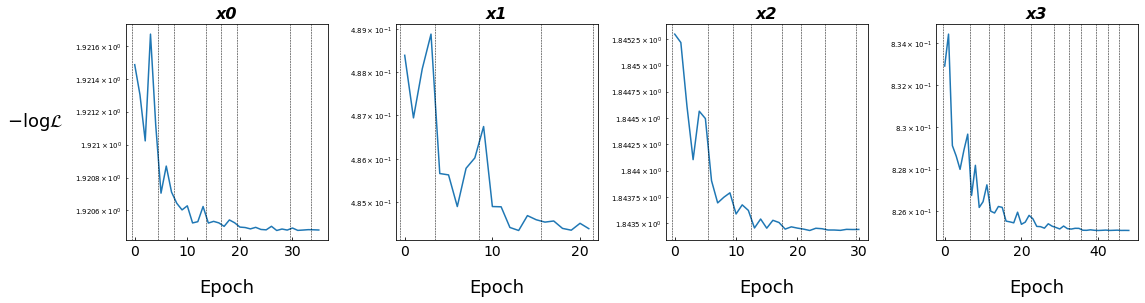

In [25]:
#  Plot loss curves
#     vertical lines are where the learning rate is updated

fig = plt.figure(figsize=(15, 3))

for obs_idx in range(num_observables) :
    model          = global_density_model.likelihood_models[obs_idx].model
    lr_record      = model.lr_record
    monitor_record = model.monitor_record
    ax = fig.add_axes([obs_idx/num_observables, 0., 0.75/num_observables, 1.])
    ax.plot(monitor_record)
    for val, lr in lr_record : ax.axvline(val-0.5, ls="--", lw=0.5, c="k")
    ax.set_yscale("log")
    ax.tick_params(which="both", direction="in", labelsize=14)
    ax.set_xlabel("Epoch", fontsize=18, labelpad=20)
    ax.tick_params(which="both", axis="y", labelsize=7)
    ax.set_title(f"x{obs_idx}", weight="bold", style="italic", fontsize=16)
    if obs_idx == 0 :
        ax.set_ylabel(r"$- \log \mathcal{L}$", fontsize=18, labelpad=40, rotation=0)
    print(f"Observable {obs_idx} trained for {len(monitor_record)} epochs")

plt.show()


##  6.  Visualise data on the latent space

We will sample a number of datapoints from the density model. We will then plot the true and generated data on the latent space, to see how well we reproduce it.

In [26]:
#  Generate data by sampling the density model at every c hypothesis in plot_c_vals

fake_projected_data = {}

if not skip_sampling :
    for row in plot_c_vals :
        for c in row :
            print(f"Generating {n_sample} datapoints at c = {c}")
            start = time.time()
            fake_projected_data[c] = global_density_model.sample(n_sample, c)
            end = time.time()
            print(f"{n_sample} datapoints generated at c = {c} in {(end-start):.2f}s")


In [27]:
#  Create method for plotting true and sampled data on the latent space

def visualise_data_latent_space (plot_c_vals, title="", savefig="") :
    prop_cycle = plt.rcParams['axes.prop_cycle']
    colours    = prop_cycle.by_key()['color']
    markers    = ['8', "x", "d", "<", "+", "v", "s", "D", "^", ">"]
    num_rows   = len(plot_c_vals)
    c_offset   = 0
    fig = plt.figure(figsize=(15, num_rows*17/2))
    for row_idx in range(num_rows) :
        c_offset = 5 if row_idx == 1 else 0
        axes = []
        for obs_idx in range(num_observables) :
            ax_top    = fig.add_axes([obs_idx/num_observables, (1-row_idx)*.5 + .45*(1-.59*.67/.95), 0.9/num_observables, .45*.58*.67/.95])
            obs_range = [-5, 5]
            hbins     = np.linspace(obs_range[0], obs_range[1], 21)
            ax_top.set_xlim([obs_range[0], obs_range[1]])
            ax_top.tick_params(axis="both", direction="in", right=True, top=True, labelsize=16, pad=5)
            ax_top.set_xticklabels([])
            if obs_idx > 0 : ax_top.set_yticklabels([])
            ypadmax, vals, vals_fake, norm, norm_fake = 0., {}, {}, {}, {}
            for c_idx, c in enumerate(plot_c_vals[row_idx]) :
                ds      = projected_data     [c][:,obs_idx]
                ds_fake = fake_projected_data[c][:,obs_idx]
                vals[c], _      = np.histogram(ds     , bins=hbins)
                vals_fake[c], _ = np.histogram(ds_fake, bins=hbins)
                norm[c]         = len(ds)
                norm_fake[c]    = len(ds_fake)
                ypadmax    = np.max([ypadmax, np.max(vals[c])])
            for c_idx, c in enumerate(plot_c_vals[row_idx]) :
                colour = colours[c_offset+c_idx] if c_idx > 0 else colours[0]
                x, y, ey = histo_to_line(hbins, vals[c], np.sqrt(vals[c]))
                y, ey = y/ypadmax, ey/ypadmax
                ax_top.plot        (x, y, lw=2, c=colour, alpha=0.6, label=None if row_idx>0 and c[0]==0 and c[1]==0 else f"{c}")
                ax_top.fill_between(x, y-ey, y+ey, alpha=0.3, fc=colour)
                if (c[0] == 0) and (c[1] == 0) : ax_top.fill_between(x, 0*y, y, alpha=0.1, fc="black")
            ax_top.set_ylim(0, 1.1)

            ax_ratio = fig.add_axes([obs_idx/num_observables, (1-row_idx)*.5 + .45*(1.-.67/.95), 0.9/num_observables, .45*.37*.67/.95])
            ax_ratio.set_xlim([obs_range[0], obs_range[1]])
            ax_ratio.tick_params(axis="both", direction="in", right=True, top=True, labelsize=16, pad=5)
            if obs_idx > 0 : ax_ratio.set_yticklabels([])
            ax_ratio.set_ylim(-0.75, 0.75)
            ax_ratio.set_yticks([-0.6, -0.4, -0.2, 0., 0.2, 0.4, 0.6])
            ax_ratio.set_xticklabels([])

            for c_idx, c in enumerate(plot_c_vals[row_idx]) :
                colour = colours[c_offset+c_idx] if c_idx > 0 else colours[0]
                x, y, ey       = histo_to_line(hbins, vals[c]    , np.sqrt(vals[c]))
                _, y_SM, ey_SM = histo_to_line(hbins, vals[(0,0)], np.sqrt(vals[(0,0)]))
                y, ey, y_SM, ey_SM = y/ypadmax, ey/ypadmax, y_SM/ypadmax, ey_SM/ypadmax
                ey_comb = np.sqrt(ey*ey + ey_SM*ey_SM)
                if (c[0] == 0) and (c[1] == 0) : ey_comb = 0.*ey_comb
                ax_ratio.plot        (x, y - y_SM, lw=2, c=colour, alpha=0.6)
                ax_ratio.fill_between(x, y - y_SM - ey_comb, y - y_SM + ey_comb, alpha=0.3, fc=colour)

            ax_ratio2 = fig.add_axes([obs_idx/num_observables, (1-row_idx)*.5, 0.9/num_observables, .45*.37*.67/.95])
            ax_ratio2.set_xlim([obs_range[0], obs_range[1]])
            ax_ratio2.tick_params(axis="both", direction="in", right=True, top=True, labelsize=16, pad=5)
            if obs_idx > 0 : ax_ratio2.set_yticklabels([])
            ax_ratio2.set_ylim(-0.05, 0.05)
            ax_ratio2.set_yticks([-0.04, -.02, 0., 0.02, 0.04])
            if row_idx == 0 :
                ax_ratio2.set_xticklabels([])
            else :
                ax_ratio2.set_xlabel(f"$u_{obs_idx}$", fontsize=20, labelpad=25, ha="center")

            ax_ratio2.axhline(0, ls="-", lw=0.8, c="grey")
            for c_idx, c in enumerate(plot_c_vals[row_idx]) :
                colour = colours[c_offset+c_idx] if c_idx > 0 else colours[0]
                x, y, ey     = histo_to_line(hbins, vals     [c], np.sqrt(vals     [c]))
                _, y_f, ey_f = histo_to_line(hbins, vals_fake[c], np.sqrt(vals_fake[c]))
                y, ey, y_f, ey_f = y/ypadmax, ey/ypadmax, y_f/ypadmax/(n_sample/n_gen), ey_f/ypadmax/(n_sample/n_gen)
                ey_comb = np.sqrt(ey*ey + ey_f*ey_f)
                for bin_idx in range(len(x)-1) :
                    x_bin, y_bin, ey_bin = x[bin_idx:bin_idx+2], (y - y_f)[bin_idx:bin_idx+2], ey_comb[bin_idx:bin_idx+2]
                    if x_bin[0] == x_bin[1] : continue
                    offset  = 0.9 * c_idx * (x_bin[1] - x_bin[0]) / len(plot_c_vals[row_idx])
                    offset += 0.05 * (x_bin[1] - x_bin[0])
                    bar_wdt = 0.9 * 0.9 * (x_bin[1] - x_bin[0]) / len(plot_c_vals[row_idx])
                    plot_bin = [x_bin[0] + offset, x_bin[0] + offset + bar_wdt]
                    ax_ratio2.plot        (plot_bin, y_bin, lw=2, c=colour, alpha=0.6)
                    #ax_ratio2.scatter(0.5*(plot_bin[0]+plot_bin[1]), y_bin[0], c=colour, alpha=0.6, marker=markers[c_idx], s=8)
                    ax_ratio2.fill_between(plot_bin, y_bin - ey_bin, y_bin + ey_bin, alpha=0.3, fc=colour)

            axes.append([ax_top, ax_ratio, ax_ratio2])

        axes[-1][0].text(1.1, 1, r"($c_x$, $c_y$) =", ha="left", va="top", fontsize=18, weight="bold", transform=axes[-1][0].transAxes)
        axes[-1][0].legend(loc=(1.05, .35 if row_idx == 0 else .55), frameon=False, fontsize=16)
        axes[0 ][0].set_ylabel(r"$\frac{p_{\rm bin}}{p_{\rm max}}$", fontsize=30, rotation=0, labelpad=55)
        axes[0 ][1].set_ylabel(r"$\frac{p_{\rm bin} - p_{\rm bin}|_{(0,0)}}{p_{\rm max}}$", fontsize=30, rotation=0, labelpad=100, va="center")
        axes[0 ][2].set_ylabel(r"$\frac{p_{\rm bin}|_{\rm model} - p_{\rm bin}|_{\rm true}}{p_{\rm max}}$", fontsize=30, rotation=0, labelpad=100, va="center")
        if (len(title) > 0) and (row_idx == 0) : axes[0][0].text(0, 1.15, title, ha="left", va="bottom", fontsize=28, weight="bold", transform=axes[0][0].transAxes)
        c_offset += len(plot_c_vals[row_idx])

    if len(savefig) > 0 : plt.savefig(savefig, bbox_inches="tight")
    plt.show()

In [28]:
#  Make plot
    
if not skip_sampling :

    visualise_data_latent_space(plot_c_vals, title="Latent space", savefig=f"figures/Figure15/Fig15_bottom_{run_tag}.pdf")


##  7. Perform inference test

First we generate the datasets used to perform the inference. We load them from a file if previously generated. This allows us to test different density models on identical observations.

In [29]:
#  Define grid of c_x and c_y values to be used a c_true

c_x_test, c_y_test = np.linspace(-0.8, 0.8, 3), np.linspace(-0.8, 0.8, 3)

c_test = []
for c_x in c_x_test :
    for c_y in c_y_test : 
        c_test.append((c_x, c_y))


# Load datasets if requested, otherwise generate new ones

if load_toy_datasets_from_file :
    print(f"Loading toy datasets from file {toy_datasets_filename}")
    toy_datasets = pickle.load(open(toy_datasets_filename, "rb"))
    
else : 
    print("Generating new toy datasets")
    toy_datasets = {}
    for c in c_test :        
        toy_datasets[tuple(c)] = generate_true_datapoints(list(c), n_true)

    print(f"Saving toy datasets to file {toy_datasets_filename}")
    pickle.dump(toy_datasets, open(toy_datasets_filename, "wb"))
    

Loading toy datasets from file ../Data/.InferTest_toy_data.pickle


In [30]:
#  Fit toy datasets and create MLEs + contours for limit setting plot
#

def do_fit (TNLL_function, c) :
    is_valid, counter = False, 0
    while (not is_valid) and (counter < 10) :
        print(f"Performing fit  (attempt {counter+1})")
        m = Minuit.from_array_func(TNLL_function, 
                                   np.array(c) + np.array([counter*np.random.uniform(-0.05, 0.05), counter*np.random.uniform(-0.05, 0.05)]), 
                                   name  = ["c_x", "c_y"],
                                   error = [0.5, 0.5], 
                                   errordef = 1)
        m.migrad()
        is_valid = m.get_fmin().is_valid
        counter += 1
    if not m.get_fmin().is_valid :
        print(f"WARNING: fit did not converge")
        return (False, m)
    return (True, m)


def get_contours (c_true, m, TNLL_function, num_pts_x=50, num_pts_y=50) :
    TNLL_min = m.fval
    c_min    = m.np_values()
    c_range  = np.array([0.4, 0.3])
    X = np.linspace(c_true[0]-c_range[0], c_true[0]+c_range[0], num_pts_x)
    Y = np.linspace(c_true[1]-c_range[1], c_true[1]+c_range[1], num_pts_y)
    X, Y = np.meshgrid(X, Y, indexing='xy')
    Z    = np.zeros_like(X)
    for j in range(num_pts_y) :
        for i in range(num_pts_x) :
            Z[j, i] = TNLL_function([X[j, i], Y[j, i]]) - TNLL_min
    return X, Y, Z
    
    
plot_data = {}
for c_true in c_test :
                    
    ds              = toy_datasets[c_true]
    projected_ds, _ = project_axes_onto_latent(ds, [float for i in range(num_observables)], axis_configs=axis_configs, whitening_funcs=projection_funcs)
    weights         = np.ones(shape=(len(projected_ds),1))
        
    print(f"Analysing ground truth at c = {c_true}")
    TNLL_true = lambda cp : -2. * evaluate_true_PDF(cp, ds)
    (converged, m_true) = do_fit (TNLL_true, c_true)
    if not converged : continue
    TNLL_min_true = m_true.fval
    c_min_true    = m_true.np_values()
    print(f"MLE at c = {c_min_true}")
    X_true, Y_true, Z_true = get_contours(c_true, m_true, TNLL_true)
    print(f"True contours evaluated")
            
    print(f"Analysing model at c = {c_true}")
    TNLL_model = lambda cp : -2. * np.sum(np.log(global_density_model.evaluate(cp, projected_ds)))
    (converged, m_model) = do_fit (TNLL_model, c_true)
    if not converged : continue
    TNLL_min_model = m_model.fval
    c_min_model    = m_model.np_values()
    print(f"MLE at c = {c_min_model}")
    X_model, Y_model, Z_model = get_contours(c_true, m_model, TNLL_model)
    print(f"True contours evaluated")
        
    plot_data[c_true] = [ds, c_min_true, X_true, Y_true, Z_true, c_min_model, X_model, Y_model, Z_model]


Analysing ground truth at c = (-0.8, -0.8)
Performing fit  (attempt 1)
MLE at c = [-0.6890284  -0.80922197]


W1209 13:20:08.734456 4696514048 deprecation.py:323] From /usr/local/lib/python3.7/site-packages/tensorflow/python/keras/engine/training_v1.py:2070: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


True contours evaluated
Analysing model at c = (-0.8, -0.8)
Performing fit  (attempt 1)
MLE at c = [-0.66464575 -0.81419683]
True contours evaluated
Analysing ground truth at c = (-0.8, 0.0)
Performing fit  (attempt 1)
MLE at c = [-8.22252582e-01 -1.58600902e-07]
True contours evaluated
Analysing model at c = (-0.8, 0.0)
Performing fit  (attempt 1)
MLE at c = [-8.08132911e-01 -6.67975252e-04]
True contours evaluated
Analysing ground truth at c = (-0.8, 0.8)
Performing fit  (attempt 1)
MLE at c = [-0.81584776  0.79788651]
True contours evaluated
Analysing model at c = (-0.8, 0.8)
Performing fit  (attempt 1)
MLE at c = [-0.81356118  0.79385004]
True contours evaluated
Analysing ground truth at c = (0.0, -0.8)
Performing fit  (attempt 1)
MLE at c = [ 0.04899217 -0.75902758]
True contours evaluated
Analysing model at c = (0.0, -0.8)
Performing fit  (attempt 1)
MLE at c = [ 0.06366323 -0.75025166]
True contours evaluated
Analysing ground truth at c = (0.0, 0.0)
Performing fit  (attempt 1)
M

q_68 is 0.989
q_95 is 3.841


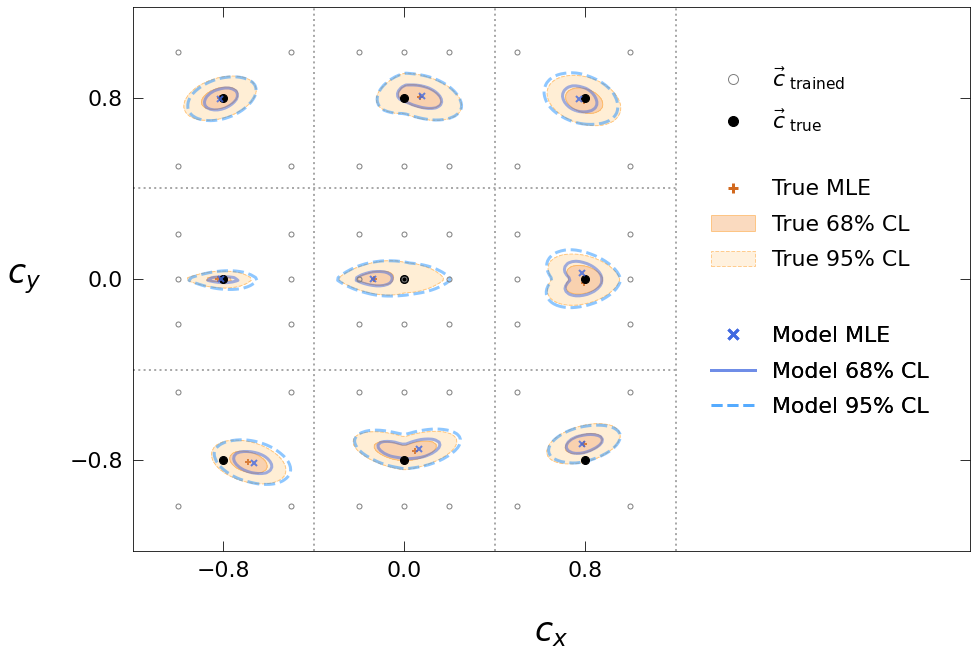

In [31]:
#  Make limit setting plot
#

q_68, q_95 = np.interp([.68, .95], stats.chi2.cdf(np.linspace(0, 5, 501), 1), np.linspace(0, 5, 501))
print(f"q_68 is {q_68:.3f}")
print(f"q_95 is {q_95:.3f}")

fig = plt.figure(figsize=(15, 10))
ax  = fig.add_subplot(1, 1, 1)
        
for c, [ds, c_min1, X1, Y1, Z1, c_min2, X2, Y2, Z2], in plot_data.items() :
    ax.contour (X1, Y1, Z1, levels=[q_68, q_95]   , colors=["darkorange", "darkorange"], linewidths=1, linestyles=["-", "--"], alpha=0.4)
    ax.contourf(X1, Y1, Z1, levels=[0, q_68, q_95], colors=["sandybrown", "navajowhite"], alpha=0.5)
    ax.plot(c_min1[0], c_min1[1], "+", c="chocolate", ms=6, mew=2, alpha=0.8)
    ax.plot(c     [0], c     [1], "o", c="black", ms=8)
    ax.contour(X2, Y2, Z2, levels=[1, 4], colors=["royalblue", "dodgerblue"], linewidths=3, linestyles=["-", "--"], alpha=0.5)
    ax.plot(c_min2[0], c_min2[1], "x", c="royalblue", ms=6, mew=2, alpha=0.8)
    
for (c_x, c_y) in c_gen :
    if np.fabs(c_x) > 1.2 : continue
    if np.fabs(c_y) > 1.2 : continue
    ax.plot(c_x, c_y, "o", fillstyle='none', c="grey", ms=5)
    
ax.set_xlim([-1.2, 2.5])
ax.set_ylim([-1.2, 1.2])
ax.plot([-1.2, 1.2], [-0.4, -0.4], lw=2, ls=":", c="darkgrey")
ax.plot([-1.2, 1.2], [ 0.4,  0.4], lw=2, ls=":", c="darkgrey")
ax.plot([-0.4, -0.4], [-1.2, 1.2], lw=2, ls=":", c="darkgrey")
ax.plot([ 0.4,  0.4], [-1.2, 1.2], lw=2, ls=":", c="darkgrey")
ax.plot([ 1.2,  1.2], [-1.2, 1.2], lw=2, ls=":", c="darkgrey")
ax.plot(-0.4, lw=2, ls="--", c="grey")
ax.plot( 0.4, lw=2, ls="--", c="grey")
ax.set_xticks([-.8, 0., .8])
ax.set_yticks([-.8, 0., .8])
ax.tick_params(axis="both", direction="in", right=True, top=True, length=10, labelsize=22, pad=10)
ax.set_xlabel("$c_x$", fontsize=33, labelpad=35)
ax.set_ylabel("$c_y$", fontsize=33, labelpad=45, rotation=0, va="center")

proxy1 = [lines.Line2D([], [], color='grey'     , marker='o', linestyle='None', markersize=10, fillstyle='none'), 
          lines.Line2D([], [], color='black'    , marker='o', linestyle='None', markersize=10)]

proxy2 = [lines.Line2D([], [], color='chocolate', marker='+', linestyle='None', markersize=10, mew=3), 
          plt.Rectangle((0,0),1,1,fc="sandybrown" ,lw=1,ec="darkorange",ls="-" ,alpha=0.4), 
          plt.Rectangle((0,0),1,1,fc="navajowhite",lw=1,ec="darkorange",ls="--",alpha=0.4)]

proxy3 = [lines.Line2D([], [], color='royalblue' , marker='x', linestyle='None', markersize=10, mew=3), 
          lines.Line2D([], [], color='royalblue' , linestyle='-' , lw=3, alpha=0.5), 
          lines.Line2D([], [], color='dodgerblue', linestyle='--', lw=3, alpha=0.5)]

leg1 = ax.legend(proxy1,
                 [r"${\vec c}_{\rm ~trained}$", r"${\vec c}_{\rm ~true}$"],
                 loc=(0.68, 0.75), frameon=False, fontsize=22, labelspacing=.7)

leg2 = ax.legend(proxy2,
                 ["True MLE", "True 68% CL", "True 95% CL"],
                 loc=(0.68, 0.50), frameon=False, fontsize=22, labelspacing=.7)

leg3 = ax.legend(proxy3,
                 ["Model MLE", "Model 68% CL", "Model 95% CL"],
                 loc=(0.68, 0.23), frameon=False, fontsize=22, labelspacing=.7)

ax.add_artist(leg1)
ax.add_artist(leg2)
ax.add_artist(leg3)

figure_fname = f"figures/paper2D_toy_model/contours_{run_tag}.pdf"
make_sure_dir_exists_for_filename(figure_fname)
plt.savefig(figure_fname, bbox_inches="tight")
plt.show()
